# Deep Cube Use Case 3: Fire Hazard Forecasting in the Mediterranean

 ![use case3 icon](static/uc3-logo.png) 

# Notebook 3: Deep Learning Models Explainability

We are interested in understanding which are the main drivers that lead to the occurrence of wildfires. To this end, we can apply explainable artificial intelligence (xAI) techniques and extract more information from the trained models besides the metrics (e.g., AUROC). This information can then be translated into usable knowledge which could help in the prevention and management strategies. 

In particular, we would like to address the following questions: 

- Which are the main drivers? 
- What are the relevant spatio-temporal patterns?
- How is fire risk affected by changes in the input? 

Answering these questions will make our models more transparent and trustworthy. 

# Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system. 

In [1]:
import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import fsspec
import zarr
import os
import torchvision
from tqdm import tqdm
import gc
from src.greece_fire_dataset import get_pixel_feature_vector, get_pixel_feature_ds
from methods.pixel_activation_maps import ActivationMaps
from captum.attr import ShapleyValues, Lime

In [64]:
np.nan_to_num(np.array([0,1,np.nan]), nan=-1.0)

array([ 0.,  1., -1.])

# Access Datacube

Let's open the dataset with xarray

In [2]:
# uncomment the lines if you download the dataset locally
# !wget -O dataset_greece.nc https://zenodo.org/record/4943354/files/dataset_greece.nc?download=1
# ds = xr.open_dataset('./dataset_greece.nc')

# comment out the following two lines if you want to access the dataset locally
url = 'https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/uc3cube.zarr'
ds = xr.open_zarr(fsspec.get_mapper(url), consolidated=True)


We see that the dataset has x,y and time dimensions.

More specifically it contains 4314 days (from 06/03/2009 to 06/12/2020) of 700x562 rasters

Dynamic variables like the `burned_areas` have all three dimensions, while static variables like `clc_2012` misses the temporal component and only has x, y dimensions.

# Load pretrained models

Pytorch lightning checkpoints are on `saved_models` directory.

The code for the models is in the `src` directory.

In [3]:
from src.greece_fire_models import CNN_fire_model, LSTM_fire_model, ConvLSTM_fire_model

In [4]:
# "dynamic_features":   ['Fpar_500m', 'Lai_500m', 'LST_Day_1km', 'LST_Night_1km', '1 km 16 days NDVI', '1 km 16 days EVI', 'era5_max_u10', 'era5_max_v10', 'era5_max_t2m', 'era5_max_tp', 'era5_min_u10', 'era5_min_v10', 'era5_min_t2m']
# "hidden_size":        16
# "lr":                 0.0001
# "lr_scheduler_gamma": 0.2
# "lr_scheduler_step":  25
# "lstm_layers":        1
# "positive_weight":    0.5
# "static_features":    ['dem_mean', 'aspect_mean', 'slope_mean', 'roads_density_2020', 'population_density']
# "weight_decay":       0.03




dynamic_features = ['Fpar_500m', 'Lai_500m', 'LST_Day_1km', 'LST_Night_1km', '1 km 16 days NDVI', '1 km 16 days EVI', 'era5_max_u10', 'era5_max_v10', 'era5_max_t2m', 'era5_max_tp', 'era5_min_u10', 'era5_min_v10', 'era5_min_t2m']
static_features= ['dem_mean', 'aspect_mean', 'slope_mean', 'roads_density_2020', 'population_density']
best_settings = {
    'lstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 64,  'lstm_layers':1, 'attention':False},
    'cnn' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16},
    'convlstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16,  'lstm_layers':1},

}
features = dynamic_features+static_features
classes = {0:"No fire", 1:"Fire"}

In [5]:
model = 'convlstm'
convlstm = ConvLSTM_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/convlstm.ckpt')

/home/jupyter-iprapas/.virtualenvs/python38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/jupyter-iprapas/.virtualenvs/python38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


# Local XAI

We select a day from the test set (year 2020) that there was a big fire

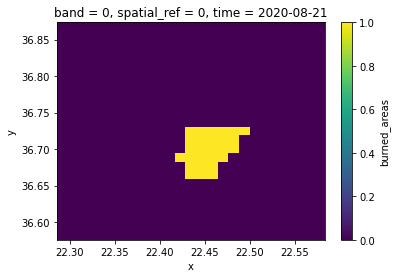

In [6]:
example = ds.sel(x=22.43, y=36.72, time='2020-08-21',method="nearest")


x = np.where(ds['x'].values==example['x'].values)[0][0]
y = np.where(ds['y'].values==example['y'].values)[0][0] 
t = np.where(ds['time'].values==example['time'].values)[0][0]

example_ds = get_pixel_feature_ds(ds, t=t, x=x, y=y, access_mode='spatiotemporal', patch_size=25, lag=10)
example_ds.burned_areas[-1].plot()

Now let's explain our model's predictions in the place that the fire occured.

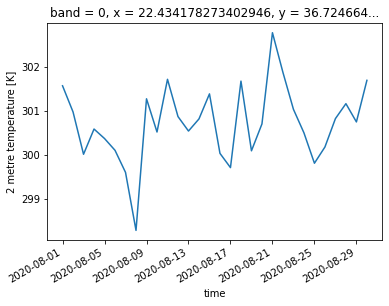

In [7]:
ds.sel(x=22.43, y=36.72, method='nearest').sel(time=slice('2020-08-01', '2020-08-30')).era5_max_t2m.plot()

In [8]:
example = ds.sel(x=22.43, y=36.72, time='2020-08-21',method="nearest")
x = np.where(ds['x'].values==example['x'].values)[0][0]
y = np.where(ds['y'].values==example['y'].values)[0][0] 
t = np.where(ds['time'].values==example['time'].values)[0][0]

In [9]:
target = torch.tensor(example.burned_areas.values)
target = torch.unsqueeze(target, 0).long()

In [33]:
model, access_mode, patch_size, lag = convlstm, 'spatiotemporal', 25, 10
dynamic, static = get_pixel_feature_vector(ds, t=t, x=x, y=y, access_mode=access_mode, patch_size=patch_size, lag=lag,
                             dynamic_features=dynamic_features,
                             static_features=static_features, nan_fill=1.0, override_whole=False)
print(dynamic.shape, static.shape)
dynamic = torch.tensor(dynamic).unsqueeze(dim=0)
static = torch.tensor(static).unsqueeze(dim=0)
model.eval()
bsize, timesteps, _, _, _ = dynamic.shape
static = static.unsqueeze(dim=1)
repeat_list = [1 for _ in range(static.dim())]
repeat_list[1] = timesteps
static = static.repeat(repeat_list)
inputs = torch.cat([dynamic, static], dim=2).float()
print(inputs.shape)
logits = model(inputs)
# positive_weight = 0.8
criterion = model.criterion
# criterion = torch.nn.NLLLoss(weight=torch.tensor([1 - positive_weight, positive_weight]))
loss = criterion(logits, target)
preds_proba = torch.exp(logits)[:, 1]
print(f'{access_mode}: {preds_proba}')

(10, 13, 25, 25) (5, 25, 25)
torch.Size([1, 10, 18, 25, 25])
spatiotemporal: tensor([0.6875], grad_fn=<SelectBackward>)


In [34]:
model.hparams

"dynamic_features":   ['Fpar_500m', 'Lai_500m', 'LST_Day_1km', 'LST_Night_1km', '1 km 16 days NDVI', '1 km 16 days EVI', 'era5_max_u10', 'era5_max_v10', 'era5_max_t2m', 'era5_max_tp', 'era5_min_u10', 'era5_min_v10', 'era5_min_t2m']
"hidden_size":        16
"lr":                 0.0001
"lr_scheduler_gamma": 0.2
"lr_scheduler_step":  25
"lstm_layers":        1
"positive_weight":    0.5
"static_features":    ['dem_mean', 'aspect_mean', 'slope_mean', 'roads_density_2020', 'population_density']
"weight_decay":       0.03

In [35]:
loss

tensor(0.3747, grad_fn=<NllLossBackward>)

Channel =  Fpar_500m


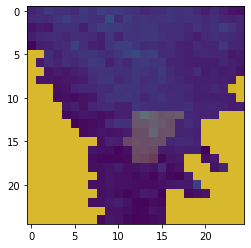

Channel =  Lai_500m


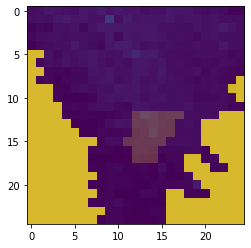

Channel =  LST_Day_1km


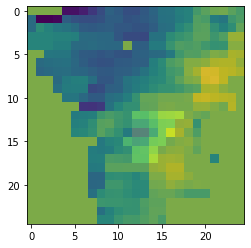

Channel =  LST_Night_1km


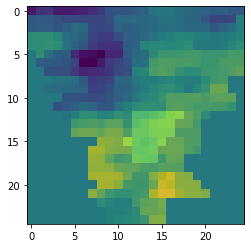

Channel =  1 km 16 days NDVI


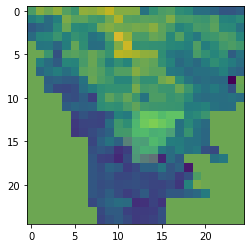

Channel =  1 km 16 days EVI


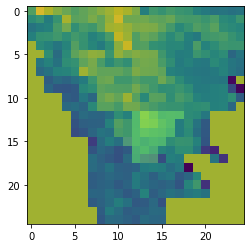

Channel =  era5_max_u10


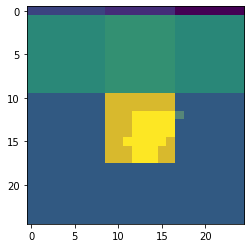

Channel =  era5_max_v10


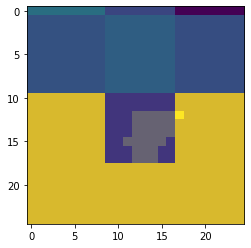

Channel =  era5_max_t2m


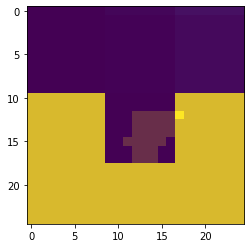

Channel =  era5_max_tp


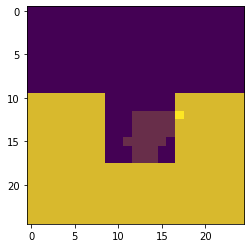

Channel =  era5_min_u10


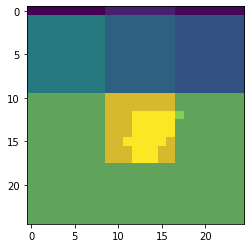

Channel =  era5_min_v10


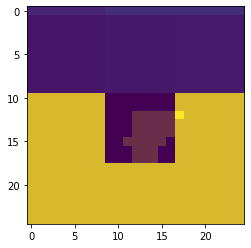

Channel =  era5_min_t2m


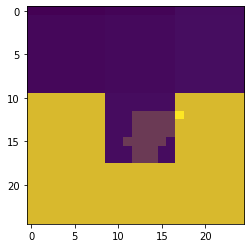

Channel =  dem_mean


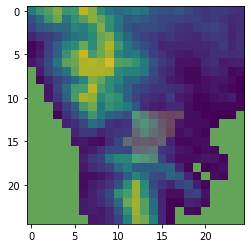

Channel =  aspect_mean


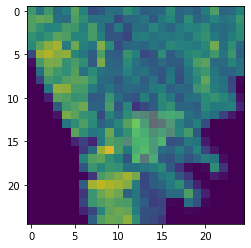

Channel =  slope_mean


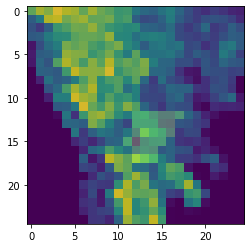

Channel =  roads_density_2020


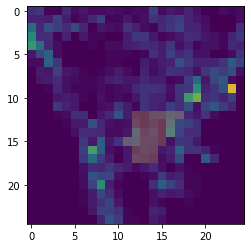

Channel =  population_density


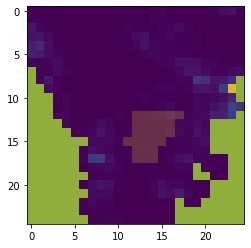

In [36]:
for i in range(len(features)):
    print("Channel = ",features[i])
    plt.imshow(inputs[0,0,i,:,:])
    plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.viridis, interpolation='none', alpha=0.2)
    plt.show()

# LIME 

Local Interpretable Model-agnostic Explanations (LIME) makes a linear approximation of the model in the proximity of the instance of interest. The coefficients of the linear approximator determine the importance of the input features. 

In [37]:
lime = Lime(model)

In [38]:
feature_mask = torch.tensor(np.ones((1, 10, 18, 25, 25)), dtype=torch.long)

for i in range(18):
    feature_mask[:,:,i,:,:] = feature_mask[:,:,i,:,:]*i

In [39]:
%%capture
attr_coarse = lime.attribute(inputs, target=1, feature_mask=feature_mask, n_samples=500, return_input_shape=False)

In [40]:
attr_coarse = attr_coarse[0,:].cpu().detach().numpy()
result = sorted(zip(list(attr_coarse),features),reverse=True)

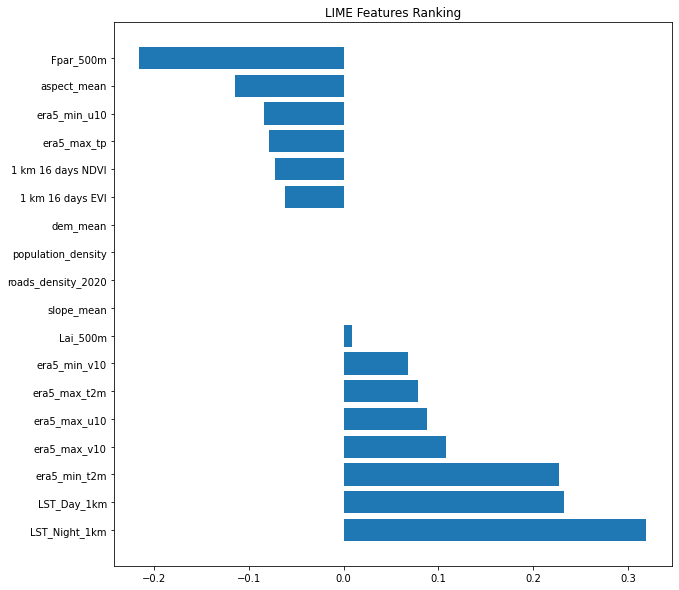

In [41]:
fi_vector, ordered_features = list(zip(*result))
plt.figure(figsize=(10,10))
plt.title("LIME Features Ranking")
plt.barh(ordered_features, fi_vector)
plt.show()

We are interested also in deriving the patterns at finer spatial and temporal scales. To do so, we can divide each channel in 5x5 windows thereby creating 25 sub-features. Then we use again LIME, this time using as input these 450 (25x18x10) finer channels. Define the windows (or sub-features): 

In [42]:
feature_mask = torch.tensor(np.ones((1, 10, 18, 25, 25)), dtype=torch.long)
rowm = np.concatenate((np.ones((5, 5)), np.ones((5, 5))*2, np.ones((5, 5))*3, np.ones((5, 5))*4, np.ones((5, 5))*5), axis=1)
fullm = np.concatenate((rowm, rowm*2, rowm*3, rowm*4, rowm*5), axis=0)
fmask = torch.tensor(fullm)

for i in range(18):
    feature_mask[:,:,i,:,:] = feature_mask[:,:,i,:,:]*(i+1)

for i in range(18):
    feature_mask[:,:,i,:,:] = feature_mask[:,:,i,:,:]*fmask*(i+1)

Fit LIME: 

In [43]:
%%capture
attr_fine = lime.attribute(inputs, target=1, feature_mask=feature_mask, n_samples=1000)

Plot most active feature windows identified by LIME per channel and the burned area on top:

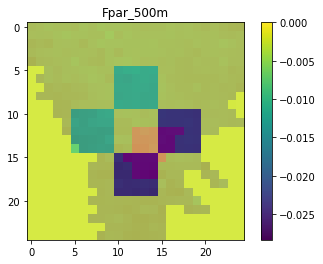

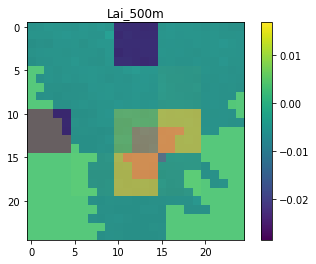

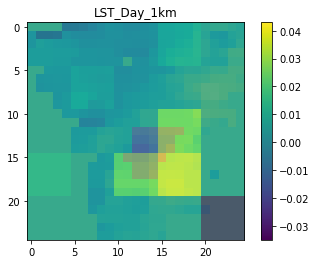

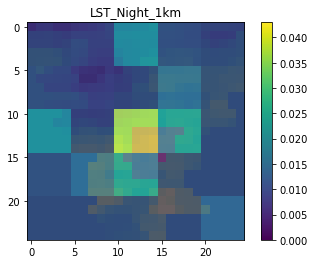

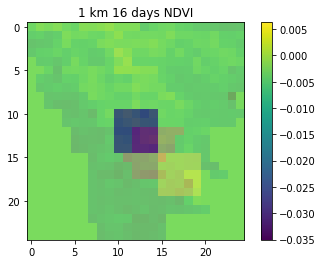

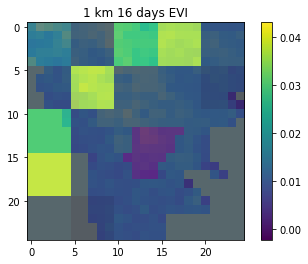

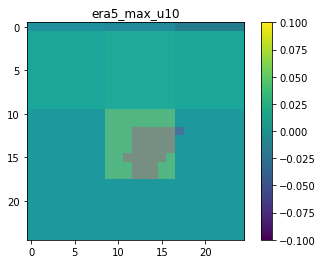

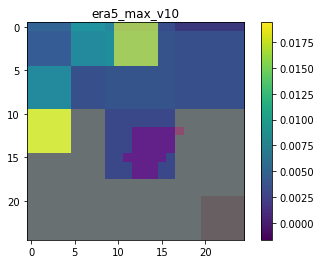

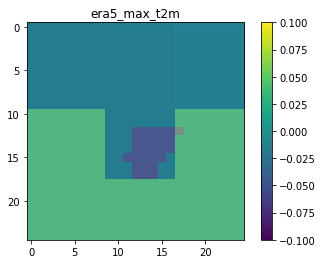

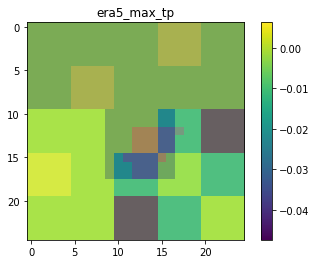

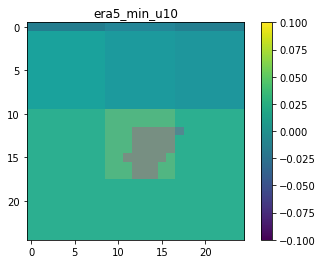

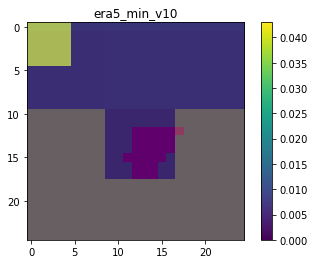

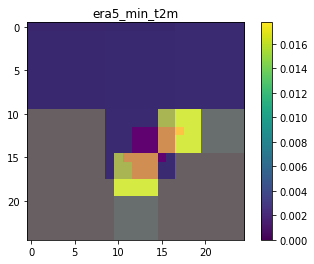

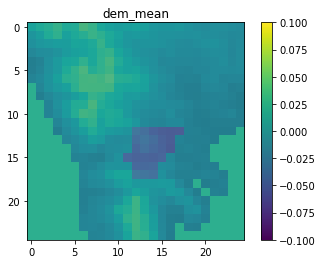

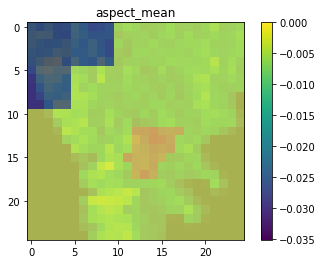

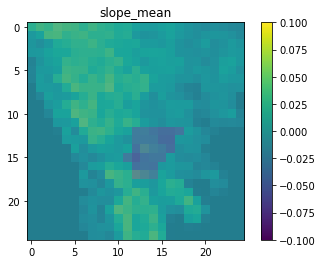

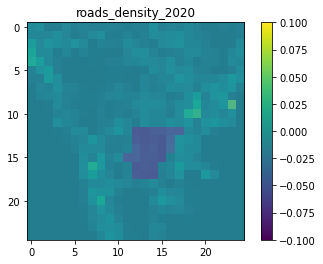

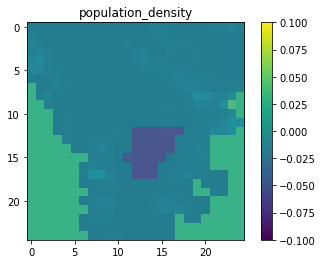

In [44]:
for i in range(len(features)):
    plt.title(features[i])
    im = plt.imshow(attr_fine[0,0,i,:,:])
    plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.cool, interpolation='none', alpha=0.2)
    plt.imshow(inputs[0,0,i,:,:], alpha = 0.25)
    plt.colorbar(im)
    plt.show()

 We compare the average of the values within the active windows with the average outside them. Below the results:

In [45]:
pos = []
neg = []
idx = features.index("era5_max_tp")

for i in range(10):
    pos.append(np.mean(inputs[0,i,idx,:,:][(attr_fine[0,0,idx,:,:]>0.1) & (inputs[0,i,idx,:,:]!=1)].cpu().detach().numpy()))
    neg.append(np.mean(inputs[0,i,idx,:,:][(attr_fine[0,6,idx,:,:]<0.1) & (inputs[0,i,idx,:,:]!=1)].cpu().detach().numpy()))

/home/jupyter-iprapas/.virtualenvs/python38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


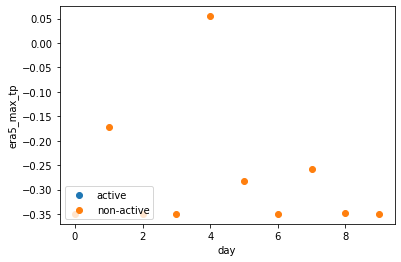

In [46]:
plt.xlabel("day")
plt.ylabel("era5_max_tp")
plt.scatter(range(10), pos, label = "active")
plt.scatter(range(10), neg, label = "non-active")
plt.legend(loc="lower left")
plt.show()

# GradCAM

Gradient-weighted Class Activations Mapping (GradCAM) gives a coarse saliency map highlighting the patterns learned by the model. The importance map is obtained by weighting the activations of the hidden layers for a specified block of the DL architecture. 
For the last convolutional block of the model we find: 

In [47]:
config = {
    "model": model,
    "instance": inputs,
    "burned_area": example_ds.burned_areas[-1],
    "value_loss": loss, 
    "pred_proba": preds_proba, 
    "y": target, 
    "method": "gradcam",
    "avg_grad": True,
    "features": features,
    "classes": classes,
    "layer": model.model.conv1,
    "plot_feature": True,
    "plot_gradient": True,
    "plot_overlay": True,
}

In [48]:
%%capture
am = ActivationMaps(config)
pix_attr, loss = am.fit()

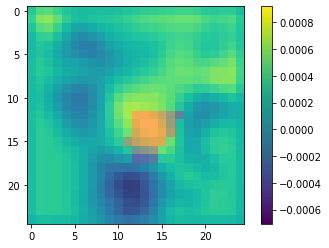

In [49]:
im = plt.imshow(pix_attr[0,0,:,:].cpu().detach().numpy())
plt.colorbar(im)
plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.cool, interpolation='none', alpha=0.25)
plt.show()

Given the above saliency map we can disentangle negative and positive patterns as follows: 

In [50]:
q3, q1 = np.percentile(pix_attr[0,0,:,:][pix_attr[0,0,:,:]!=0].flatten().cpu().detach().numpy(), [95, 5])
maskpos = torch.zeros((25, 25), dtype = torch.float64)
maskneg = torch.zeros((25, 25), dtype = torch.float64)
maskpos[pix_attr[0,0,:,:]>q3]=1
maskneg[pix_attr[0,0,:,:]<q1] = 1

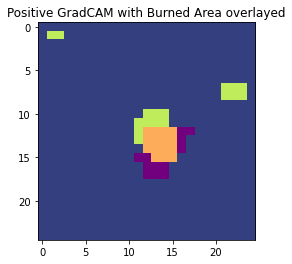

In [51]:
plt.title("Positive GradCAM with Burned Area overlayed")
plt.imshow(maskpos)
plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.cool, interpolation='none', alpha=0.25)
plt.show()

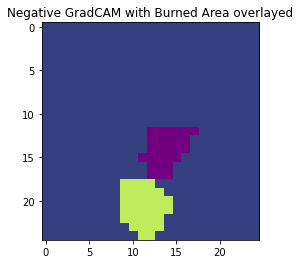

In [52]:
plt.title("Negative GradCAM with Burned Area overlayed")
plt.imshow(maskneg)
plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.cool, interpolation='none', alpha=0.25)
plt.show()

# Vanilla Gradients 

In order to get activations map per each channel we can compute the gradients with respect to the inputs as below:

In [53]:
config = {
    "model": model,
    "instance": inputs,
    "burned_area": example_ds.burned_areas[-1],
    "value_loss": loss, 
    "pred_proba": preds_proba, 
    "y": target, 
    "method": "gradient",
    "avg_grad": True,
    "features": features,
    "classes": classes,
    "layer": model.model.conv1,
    "plot_feature": True,
    "plot_gradient": True,
    "plot_overlay": True,
}

In [54]:
%%capture
am = ActivationMaps(config)
grad, loss = am.fit()

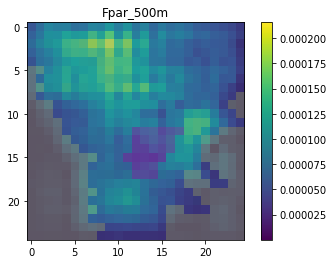

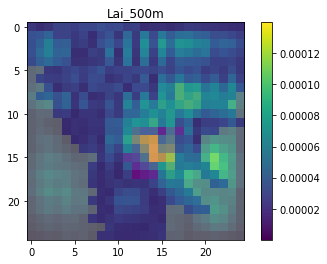

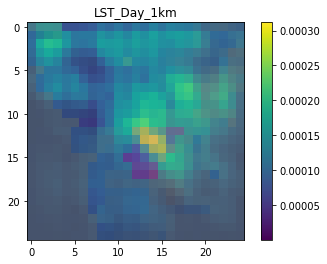

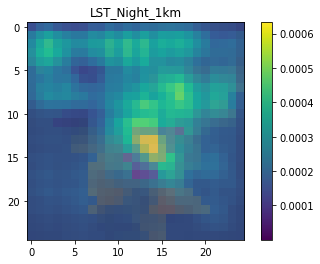

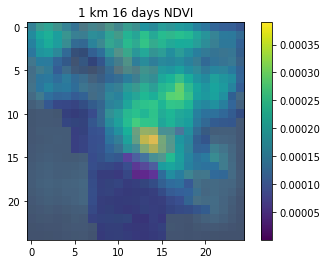

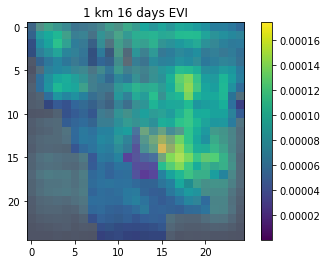

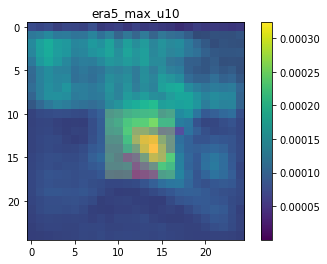

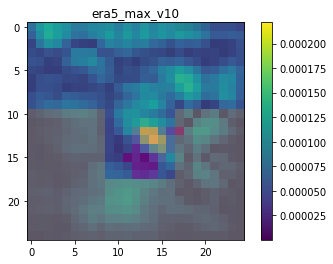

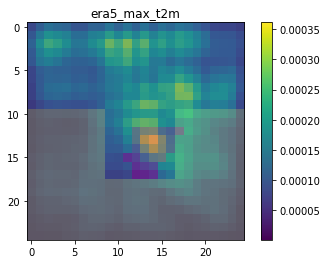

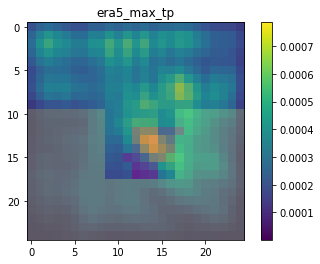

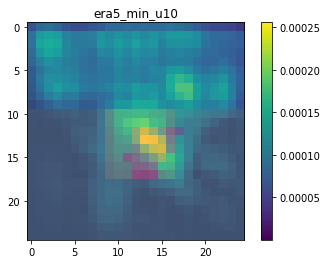

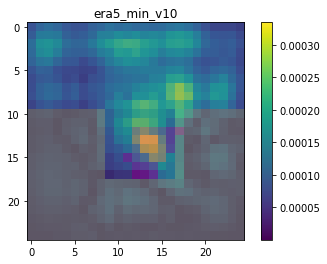

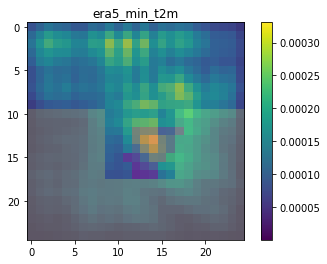

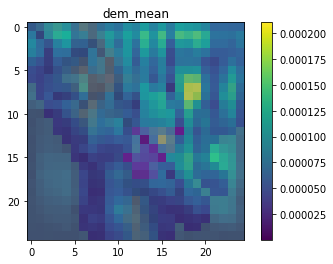

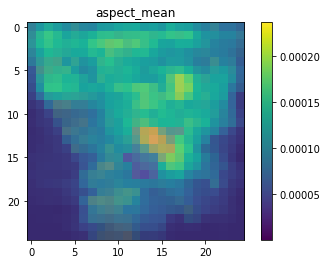

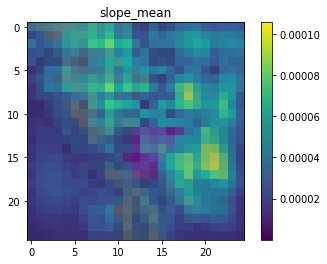

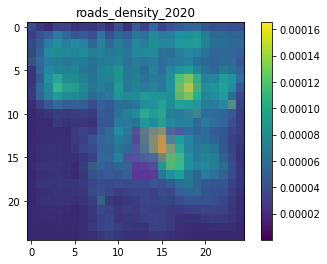

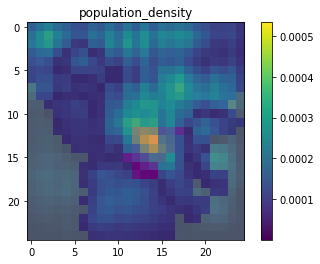

In [55]:
for i in range(len(features)):
    plt.title(features[i])
    im = plt.imshow(grad[0,9,i,:,:])
    plt.imshow(example_ds.burned_areas[-1], cmap=plt.cm.cool, interpolation='none', alpha=0.2)
    plt.imshow(inputs[0,0,i,:,:], alpha = 0.2)
    plt.colorbar(im)
    plt.show()

Finally, we can compute the spatial average of the gradients over the negative and positive masks, obtained above with GradCAM. We get the following results for LST_Night_1km

Text(0, 0.5, 'avg activation')

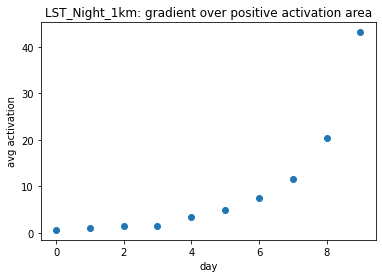

In [56]:
meantp = []

for i in range(10):
    maskgrad = maskpos.cpu().detach().numpy()*grad[0,i,3,:,:].cpu().detach().numpy()
    maskgrad[inputs[0,i, 3, :,:]==1] = 0
    maskgrad = maskgrad.flatten()
    maskgrad = maskgrad[maskgrad!=0]
    meantp.append(np.mean(maskgrad)*10**5)

plt.scatter(range(10), meantp)
plt.title(features[3]+": gradient over positive activation area")
plt.xlabel("day")
plt.ylabel("avg activation")

Text(0, 0.5, 'avg activation')

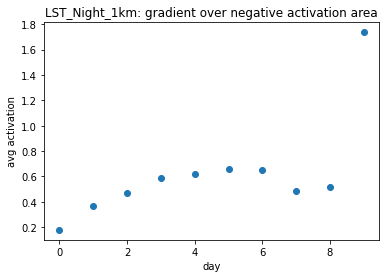

In [57]:
meantn = []

for i in range(10):
    maskgrad = maskneg.cpu().detach().numpy()*grad[0,i,3,:,:].cpu().detach().numpy()
    maskgrad[inputs[0,i, 3, :,:]==1] = 0
    maskgrad = maskgrad.flatten()
    maskgrad = maskgrad[maskgrad!=0]
    meantn.append(np.mean(maskgrad)*10**5)

plt.scatter(range(10), meantn)
plt.title(features[3]+": gradient over negative activation area")
plt.xlabel("day")
plt.ylabel("avg activation")

# Discussion

In this notebook we have seen how to use different explainable AI methods to create saliency maps and calculate importance scores for the input features. This is useful to understand why specific instances are classified with high fire risk and thus learn which are the main patterns (temporal, spatial and features) that drive the occurrence of large fires. Stay tuned! 

# Acknowledgements

Research funded by the EU H2020 project DeepCube ’Explainable AI pipelines for big Copernicus data’, grant agreement No 101004188.

Notebook Author: *Michele Ronco (https://github.com/mikronco)*